In [1]:
import numpy as np
import tensorflow as tf
from gpflow import set_trainable
from gpflow.ci_utils import ci_niter
from gpflow.kernels import RBF
from gpflow.likelihoods import Gaussian
from matplotlib import pyplot as plt
from markovflow.kernels import Matern32
from markovflow.models import SpatioTemporalSparseCVI
from markovflow.ssm_natgrad import SSMNaturalGradient

np.random.seed(10)

2022-09-17 15:52:34.910158: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-09-17 15:52:34.910189: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Declaring the model

In [2]:
M_time = 7
M_space = 7
T = 5.0

kernel_space = RBF(variance=1.0, lengthscales=0.5)
kernel_time = Matern32(variance=1.0, lengthscale=T / 2.0)
likelihood = Gaussian(variance=0.1)

inducing_space = np.linspace(0.1, 0.9, M_space).reshape(-1, 1)
inducing_time = np.linspace(0, T, M_time).reshape(-1,)

model = SpatioTemporalSparseCVI(
    inducing_time=tf.identity(inducing_time),
    inducing_space=tf.identity(inducing_space),
    kernel_space=kernel_space,
    kernel_time=kernel_time,
    likelihood=likelihood,
)

Instructions for updating:
Do not call `graph_parents`.


2022-09-17 15:52:36.575284: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-17 15:52:36.575459: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-09-17 15:52:36.575470: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-17 15:52:36.575488: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az178-774): /proc/driver/nvidia/version does not exist
2022-09-17 15:52:36.575729: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F F

In [3]:
# Creating data
num_data = 500
std_noise = 0.5
time_points = np.random.uniform(0, T, num_data).reshape(-1, 1)
space_points = np.random.rand(num_data, 1)
X = np.concatenate([space_points, time_points], -1)
f = lambda v: np.cos(5.0 * (v[..., 1:] + v[..., :1]))
F = f(X)
Y = F + np.random.randn(num_data, 1) * std_noise
data = (X, Y)

Creating a plotting grid and plotting function

In [4]:
x_grid, t_grid = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, T, 50))
X_grid = np.concatenate([x_grid.reshape(-1, 1), t_grid.reshape(-1, 1)], axis=-1)


def plot_model(model):
    mu_f, var_f = model.space_time_predict_f(X_grid)
    fig, axarr = plt.subplots(2, 1)
    axarr[0].scatter(x=time_points, y=space_points, c=Y)
    axarr[1].scatter(x=X_grid[..., 1:], y=X_grid[..., :1], c=mu_f.numpy())

    axarr[1].hlines(
        model.inducing_space, xmin=time_points.min(), xmax=time_points.max(), colors="r"
    )
    axarr[1].vlines(
        model.inducing_time, ymin=space_points.min(), ymax=space_points.max(), colors="k"
    )

    plt.savefig("spatio_temporal.png", dpi=300)
    plt.show()

Training

In [5]:
# Start at a small learning rate
adam_learning_rate = 0.05
natgrad_learning_rate = 0.5

adam_opt = tf.optimizers.Adam(learning_rate=adam_learning_rate)
natgrad_opt = SSMNaturalGradient(gamma=natgrad_learning_rate, momentum=False)

set_trainable(model.nat2, False)
set_trainable(model.nat1, False)

adam_var_list = model.kernel.trainable_variables  # trainable_variables
print(adam_var_list)
set_trainable(model.nat2, True)
set_trainable(model.nat1, True)

(<tf.Variable 'lengthscale:0' shape=() dtype=float64, numpy=2.414349516257962>, <tf.Variable 'variance:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.43275212956718856>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>)


2022-09-17 15:52:36.741501: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [6]:
@tf.function
def loss(input_data):
    return model.loss(input_data)


@tf.function
def opt_step(input_data):
    model.update_sites(input_data)
    adam_opt.minimize(lambda: loss(input_data), adam_var_list)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


2022-09-17 15:53:05.363037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


2022-09-17 15:53:06.411842: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2793435000 Hz


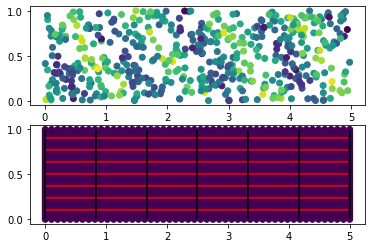

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=2.545988617323153>


Iteration: 0 , Loss: 5725.468712193918


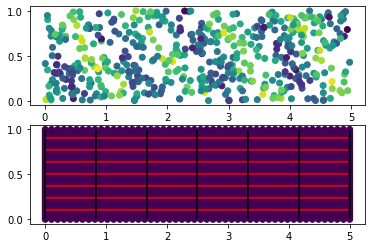

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=3.5278962309851702>


Iteration: 20 , Loss: 3217.6838262915585


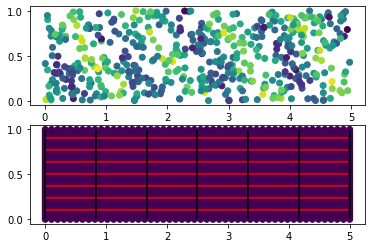

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=4.445691085704647>


Iteration: 40 , Loss: 2475.118745127726


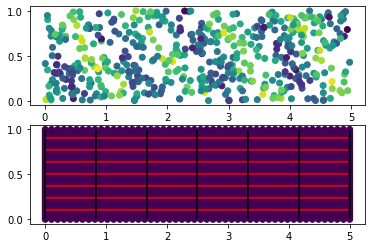

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=5.347363838976735>


Iteration: 60 , Loss: 2203.6051946206235


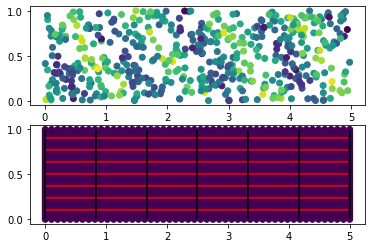

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=6.727550812618156>


Iteration: 80 , Loss: 2066.168491166244


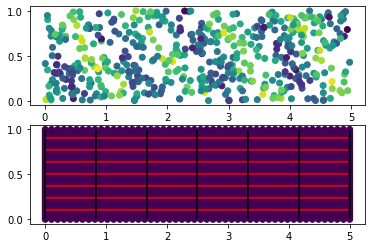

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=8.308900362090853>


Iteration: 100 , Loss: 1978.7823494059448


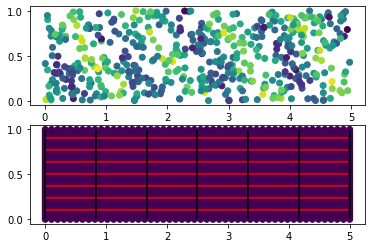

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.101153048078817>


Iteration: 120 , Loss: 1922.5401600241235


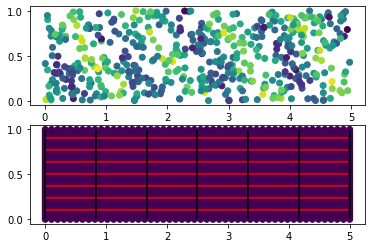

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.327628550228047>


Iteration: 140 , Loss: 1886.2405945772198


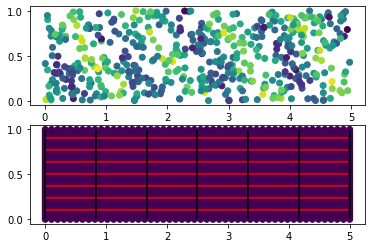

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.40199936030024>


Iteration: 160 , Loss: 1860.2603894827917


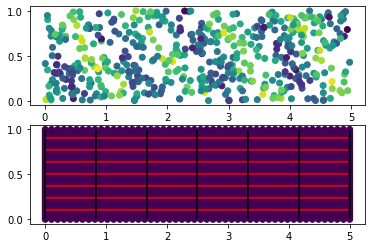

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.438750536878398>


Iteration: 180 , Loss: 1840.8094183506723


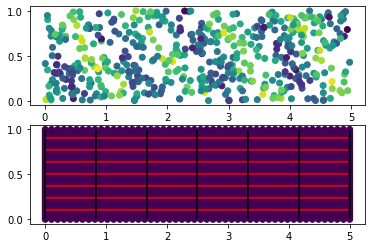

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.463108364741975>


Iteration: 200 , Loss: 1825.7944352705417


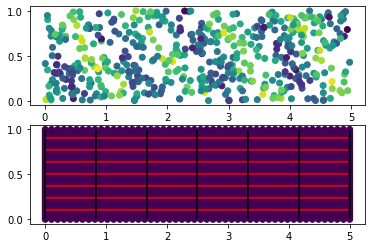

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.481558652965461>


Iteration: 220 , Loss: 1813.919946029135


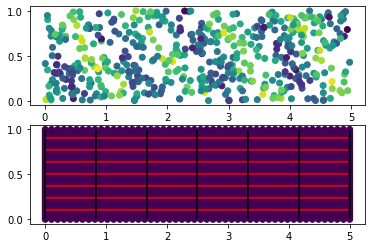

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.49641400849563>


Iteration: 240 , Loss: 1804.3398047826176


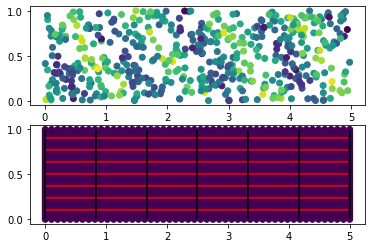

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.508798118825707>


Iteration: 260 , Loss: 1796.4797156710797


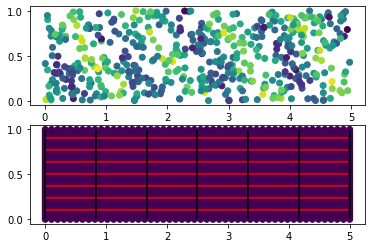

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.519370116665884>


Iteration: 280 , Loss: 1789.9375895303497


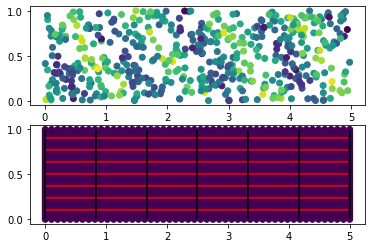

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.528557676695737>


Iteration: 300 , Loss: 1784.4244270021009


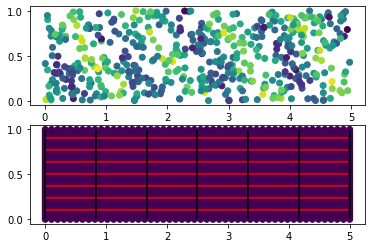

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.53665552160601>


Iteration: 320 , Loss: 1779.727772157424


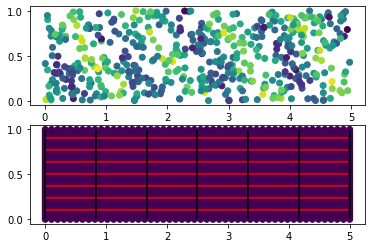

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.543875421835033>


Iteration: 340 , Loss: 1775.6883397244121


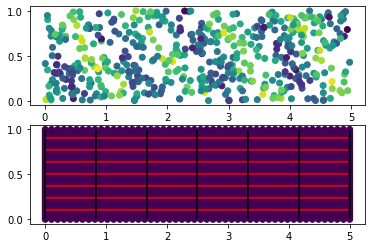

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.550374487003015>


Iteration: 360 , Loss: 1772.1846261759392


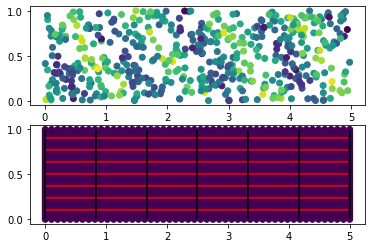

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.556272317649789>


Iteration: 380 , Loss: 1769.1225168255428


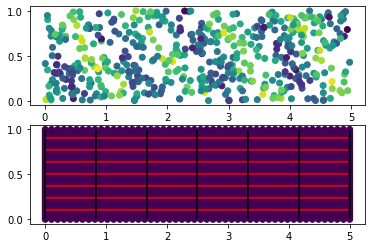

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.561661930528816>


Iteration: 400 , Loss: 1766.4281077331143


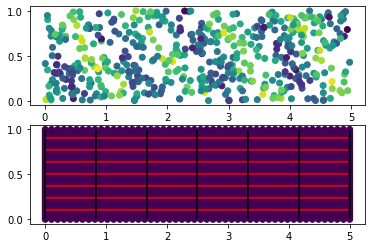

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.566616991954945>


Iteration: 420 , Loss: 1764.0426479282983


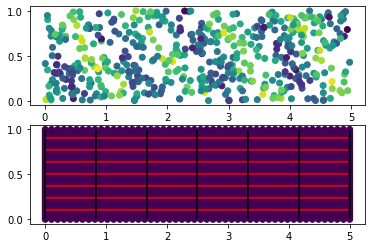

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.571196761145675>


Iteration: 440 , Loss: 1761.9189111948258


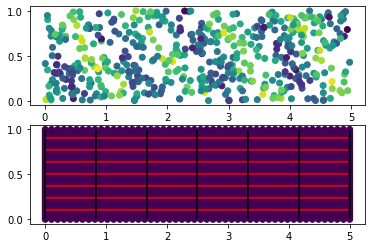

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.575449560209035>


Iteration: 460 , Loss: 1760.0185509342523


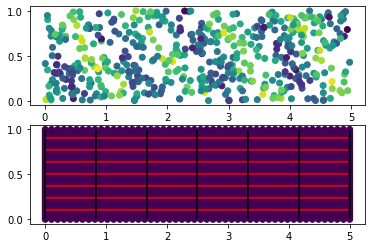

<Parameter: dtype=float64, shape=[], fn="softplus", numpy=9.579415266613418>


Iteration: 480 , Loss: 1758.3101432574022


In [7]:
max_iter = ci_niter(500)

for i in range(max_iter):
    opt_step(data)
    if i % 20 == 0:
        plot_model(model)
        print(model.kernel.kernel_time.lengthscale)
        print("Iteration:", i, ", Loss:", model.loss(data).numpy())